In [1]:
import hashlib, os, optparse, sys
import matplotlib.pyplot as plt
import numpy as np
import glob
import shutil
import random
import os
import cv2
import imghdr
import json
from PIL import Image
import tensorflow as tf
from simple_image_download import simple_image_download as simp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.python.keras.preprocessing import image as KerasImage
import tensorflow_hub as hub
import datetime


In [2]:
# import classes from artstyle.py

from artstyle import ArtstyleConfig, ArtstyleDataset, ArtstyleModel
from artstyle import model_dir, dataset_dir, base_dir


In [3]:
# init configurations

config = ArtstyleConfig()


-------------------------
IMAGE_SIZE: 224
BATCH_SIZE: 32
MODEL_CLASSES: {'0': 'cubism', '1': 'ghibli', '2': 'impressionism'}
-------------------------


In [4]:
def plotImages(images, cols=5, cvformat=True):
    rows = len(images) // cols + 1
    plt.figure(figsize=(20, 20 * rows // cols))
    i = 1
    for img in images:
        plt.subplot(rows, cols, i)
        
        if cvformat:
            img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img_cvt)
        
        plt.imshow(img)
        i += 1

    plt.show()

In [5]:
# init dataset

dataset = ArtstyleDataset(config)

In [32]:
dataset.download_from_google("cubism", [
            # ('cubism', 1000),
            ('cubism picasso', 400),
            ('juan gris cubism', 200),
            ('georges braque cubism', 100),
            ('jean metzinger cubism',200)
        ])

[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


In [33]:
dataset.download_from_google("ghibli", [ 
            # ('ghibli', 1000),
            ('hayao miyazaki sketches watercolor', 300),
            ('hayao miyazaki sketches watercolor nausicaa', 200),
            ('hayao miyazaki sketches watercolor kiki''s delivery', 100),
            ('hayao miyazaki sketches watercolor concept art', 300),
            ('hayao miyazaki sketches watercolor castle', 50),
            ('hayao miyazaki sketches watercolor princess mononoke', 50),
            ('hayao miyazaki sketches ponyo', 300),
            ('hayao miyazaki sketches fireflies', 300),
            ('hayao miyazaki sketches watercolor porco rosso', 100),
            ('hayao miyazaki sketches watercolor wind', 200),
        ])

[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


In [34]:
dataset.download_from_google("impressionism", [
            # ('impressionism', 1000),
            ('monet', 500),
            ('corot impressionism', 300),
            ('van gogh original paintings', 400),
            ('monet water lilies', 50),
            ('monet haystacks', 50),
            ('monet trees', 200),
        ])

[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


In [35]:
# remove duplicated images

dataset.remove_duplicated_images()


Removing duplicated images
Working in path content/datasets\cubism ...

Done! Following files will be deleted:

content/datasets\cubism\cubism picasso_23.jpeg
content/datasets\cubism\cubism picasso_4.jpeg
content/datasets\cubism\georges braque cubism_1.jpeg

Enter (y)es to confirm operation or anything else to abort: y
Deleting...
Done! Found and deleted 3 files...
Working in path content/datasets\ghibli ...

Done! Following files will be deleted:

content/datasets\ghibli\hayao miyazaki sketches ponyo_1.jpeg
content/datasets\ghibli\hayao miyazaki sketches ponyo_19.jpeg
content/datasets\ghibli\hayao miyazaki sketches watercolor castle_20.jpeg
content/datasets\ghibli\hayao miyazaki sketches watercolor concept art_29.jpeg
content/datasets\ghibli\hayao miyazaki sketches watercolor kikis delivery_45.jpeg
content/datasets\ghibli\hayao miyazaki sketches watercolor princess mononoke_19.jpeg
content/datasets\ghibli\hayao miyazaki sketches watercolor wind_22.jpeg
content/datasets\ghibli\hayao mi

In [7]:
# from about 400~500 per class  => 2000+ per classes

dataset.tile()

cubism: tiling completed
ghibli: tiling completed
impressionism: tiling completed


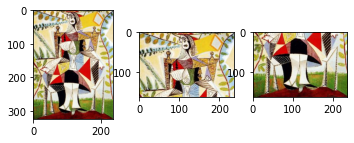

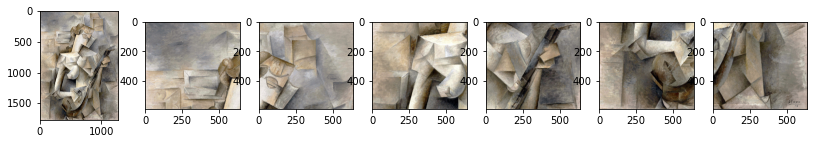

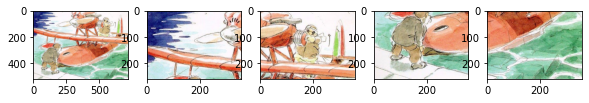

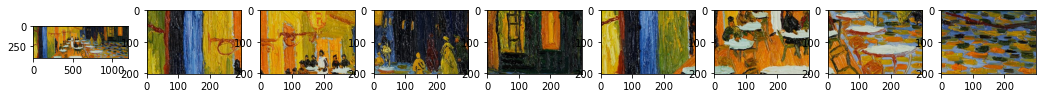

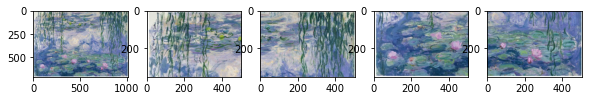

In [10]:
# test the image tiling function

tiles = dataset.tile_image(os.path.join(dataset_dir, "cubism/1.jpg"))
plotImages(tiles, cols=10, cvformat=True)

tiles = dataset.tile_image(os.path.join(dataset_dir, "cubism/cubism picasso_1.jpeg"))
plotImages(tiles, cols=10, cvformat=True)

tiles = dataset.tile_image(os.path.join(dataset_dir, "ghibli/hayao miyazaki sketches watercolor porco rosso_1.jpeg"))
plotImages(tiles, cols=10, cvformat=True)

tiles = dataset.tile_image(os.path.join(dataset_dir, "impressionism/van gogh original paintings_1.jpeg"))
plotImages(tiles, cols=10, cvformat=True)

tiles = dataset.tile_image(os.path.join(dataset_dir, "impressionism/monet water lilies_1.jpeg"))
plotImages(tiles, cols=10, cvformat=True)

In [7]:
# Split dataset into training and validation

dataset.split()


1340 Images from content/datasets\cubism => content/datasets\photos\train\cubism
335 Images from content/datasets\cubism => content/datasets\photos\val\cubism
1523 Images from content/datasets\ghibli => content/datasets\photos\train\ghibli
381 Images from content/datasets\ghibli => content/datasets\photos\val\ghibli
1679 Images from content/datasets\impressionism => content/datasets\photos\train\impressionism
420 Images from content/datasets\impressionism => content/datasets\photos\val\impressionism


In [10]:
# create model for training

model = ArtstyleModel("training", config)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
# num_classes = 3

# URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
# feature_extractor = hub.KerasLayer(URL,
#                                    input_shape=(config.IMAGE_SIZE, config.IMAGE_SIZE, 3))

# feature_extractor.trainable = False

# m = tf.keras.Sequential([
#   feature_extractor,
#   tf.keras.layers.Dense(num_classes)
# ])

# m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


Found 4547 images belonging to 3 classes.


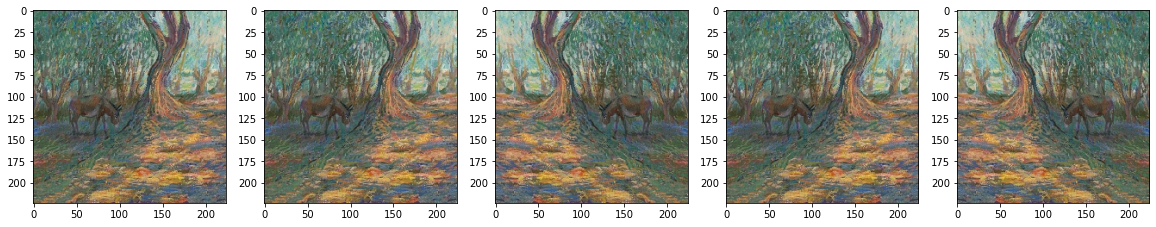

In [26]:
# Create data generator to feed images from dataset folders to the training model

# A data generator uses "image augmentation" to randomly modify input data
# in order to increase the data diversity and reduce model overfitting

# Example: randowm flip augmentation
image_gen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True
)

data_generator = image_gen.flow_from_directory(batch_size=config.BATCH_SIZE,
                                               directory=os.path.join(base_dir, "train"),
                                               shuffle=True,
                                               target_size=(config.IMAGE_SIZE,config.IMAGE_SIZE))

# check an image from the data generator
augmented_images = [data_generator[0][0][0] for i in range(5)]
plotImages(augmented_images, cvformat=False)


Found 4547 images belonging to 3 classes.


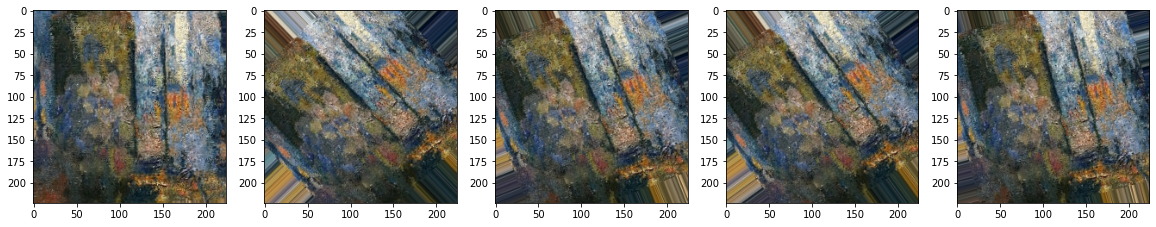

In [27]:
# Example: randowm rotation augmentation

image_gen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=45
)

data_generator = image_gen.flow_from_directory(batch_size=config.BATCH_SIZE,
                                               directory=os.path.join(base_dir, "train"),
                                               shuffle=True,
                                               target_size=(config.IMAGE_SIZE,config.IMAGE_SIZE))

# check an image from the data generator
augmented_images = [data_generator[0][0][0] for i in range(5)]
plotImages(augmented_images, cvformat=False)


Found 4547 images belonging to 3 classes.


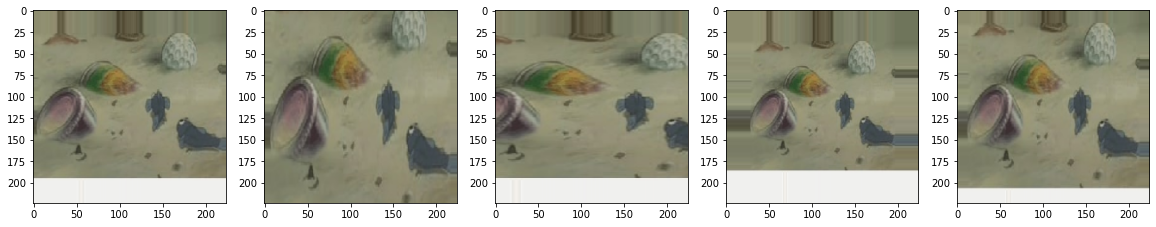

In [29]:
# Example: randowm zooming augmentation

image_gen = ImageDataGenerator(
    rescale=1./255, 
    zoom_range=0.5
)

data_generator = image_gen.flow_from_directory(batch_size=config.BATCH_SIZE,
                                               directory=os.path.join(base_dir, "train"),
                                               shuffle=True,
                                               target_size=(config.IMAGE_SIZE,config.IMAGE_SIZE))

# check an image from the data generator
augmented_images = [data_generator[0][0][0] for i in range(5)]
plotImages(augmented_images, cvformat=False)


Found 4547 images belonging to 3 classes.


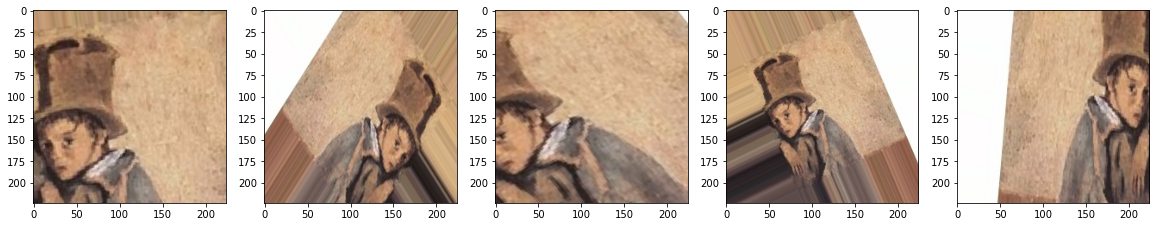

In [6]:
# Put all augmentation methods together

# create data generator for the training dataset
image_gen_train = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,
    fill_mode='nearest'
)

train_data_generator = image_gen_train.flow_from_directory(batch_size=config.BATCH_SIZE,
                                                     directory=os.path.join(base_dir, "train"),
                                                     shuffle=True,
                                                     target_size=(config.IMAGE_SIZE,config.IMAGE_SIZE),
                                                     class_mode='sparse')

# check an image in the data generator
augmented_images = [train_data_generator[0][0][0] for i in range(5)]
plotImages(augmented_images, cvformat=False)

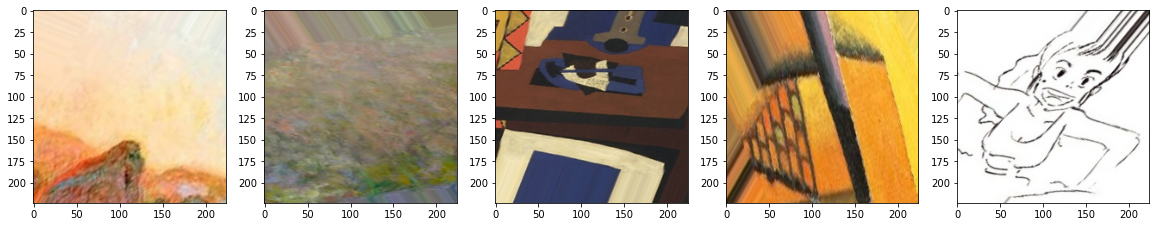

In [7]:
# check more images in the train_data_generator
sample_training_images, _ = next(train_data_generator)
plotImages(sample_training_images[:5], cvformat=False)

Found 1136 images belonging to 3 classes.


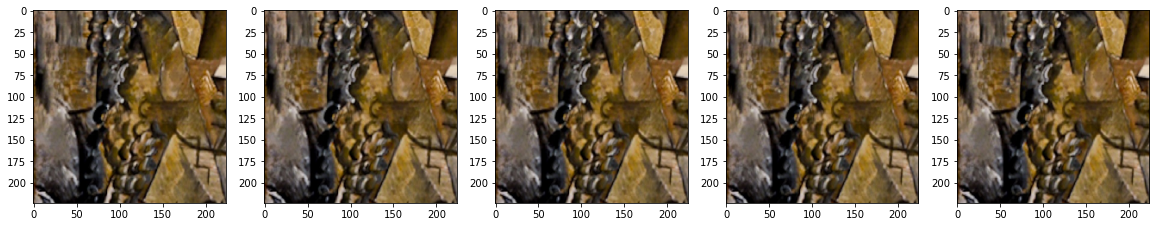

In [9]:
# create data generator for the validation dataset
# no need for image augmentation
image_gen_val = ImageDataGenerator(
    rescale=1./255
)

val_data_generator = image_gen_val.flow_from_directory(batch_size=config.BATCH_SIZE,
                                                 directory=os.path.join(base_dir, "val"),
                                                 target_size=(config.IMAGE_SIZE, config.IMAGE_SIZE),
                                                 class_mode='sparse')

# check an image in the data generator
augmented_images = [val_data_generator[0][0][0] for i in range(5)]
plotImages(augmented_images, cvformat=False)



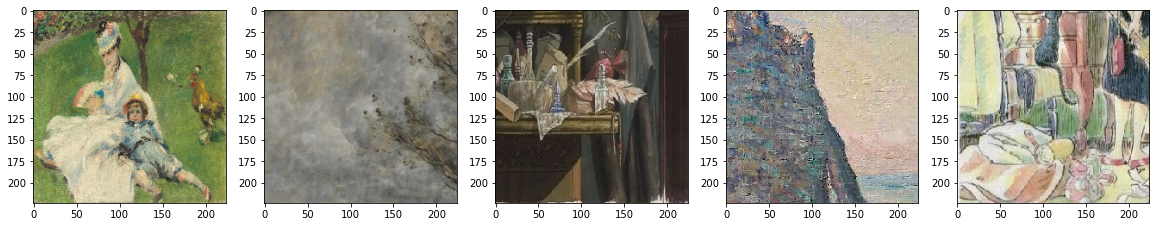

In [10]:
# check more images in the val_data_generator
sample_val_images, _ = next(val_data_generator)
plotImages(sample_val_images[:5], cvformat=False)

In [15]:
# train the model

epochs = 50
history = model.train(base_dir, epochs=epochs)


Found 4547 images belonging to 3 classes.
Found 1136 images belonging to 3 classes.
Classes for training: {0: 'cubism', 1: 'ghibli', 2: 'impressionism'}

Loaded 4547 images for training
Loaded 1136 images for validation
Epoch 1/50
142/142 [==============================] - 67s 470ms/step - loss: 0.7425 - accuracy: 0.8330 - val_loss: 0.6770 - val_accuracy: 0.8911
Epoch 2/50
142/142 [==============================] - 66s 464ms/step - loss: 0.6685 - accuracy: 0.8957 - val_loss: 0.6667 - val_accuracy: 0.8955
Epoch 3/50
142/142 [==============================] - 66s 465ms/step - loss: 0.6585 - accuracy: 0.8992 - val_loss: 0.6627 - val_accuracy: 0.8982
Epoch 4/50
142/142 [==============================] - 66s 463ms/step - loss: 0.6451 - accuracy: 0.9116 - val_loss: 0.6389 - val_accuracy: 0.9223
Epoch 5/50
142/142 [==============================] - 70s 495ms/step - loss: 0.6421 - accuracy: 0.9141 - val_loss: 0.6428 - val_accuracy: 0.9152
Epoch 6/50
142/142 [==============================] - 6

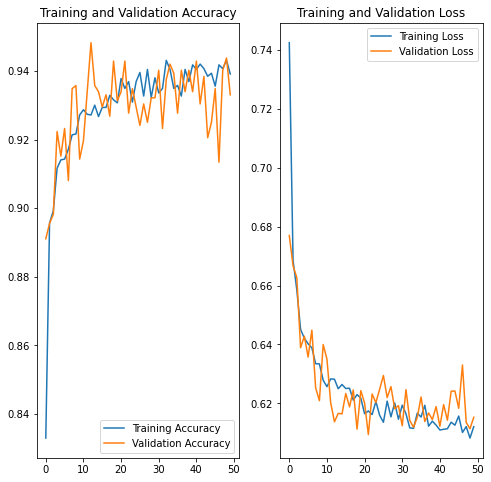

In [16]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
# reload model from .h5 file
model = ArtstyleModel("inference", 
                      config, 
                      model_path="model/artstyle_20210102T1718_0.9330.h5") 
    


Model loaded from: model/artstyle_20210102T1718_0.9330.h5

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


Found 75 images belonging to 3 classes.
test_classes:  {0: 'cubism', 1: 'ghibli', 2: 'impressionism'}

Evaluation completed. 
======97.33% correct. 

Missed 2 out of total 75 images:
[MISSED] ghibli -> impressionism 
[MISSED] impressionism -> ghibli 



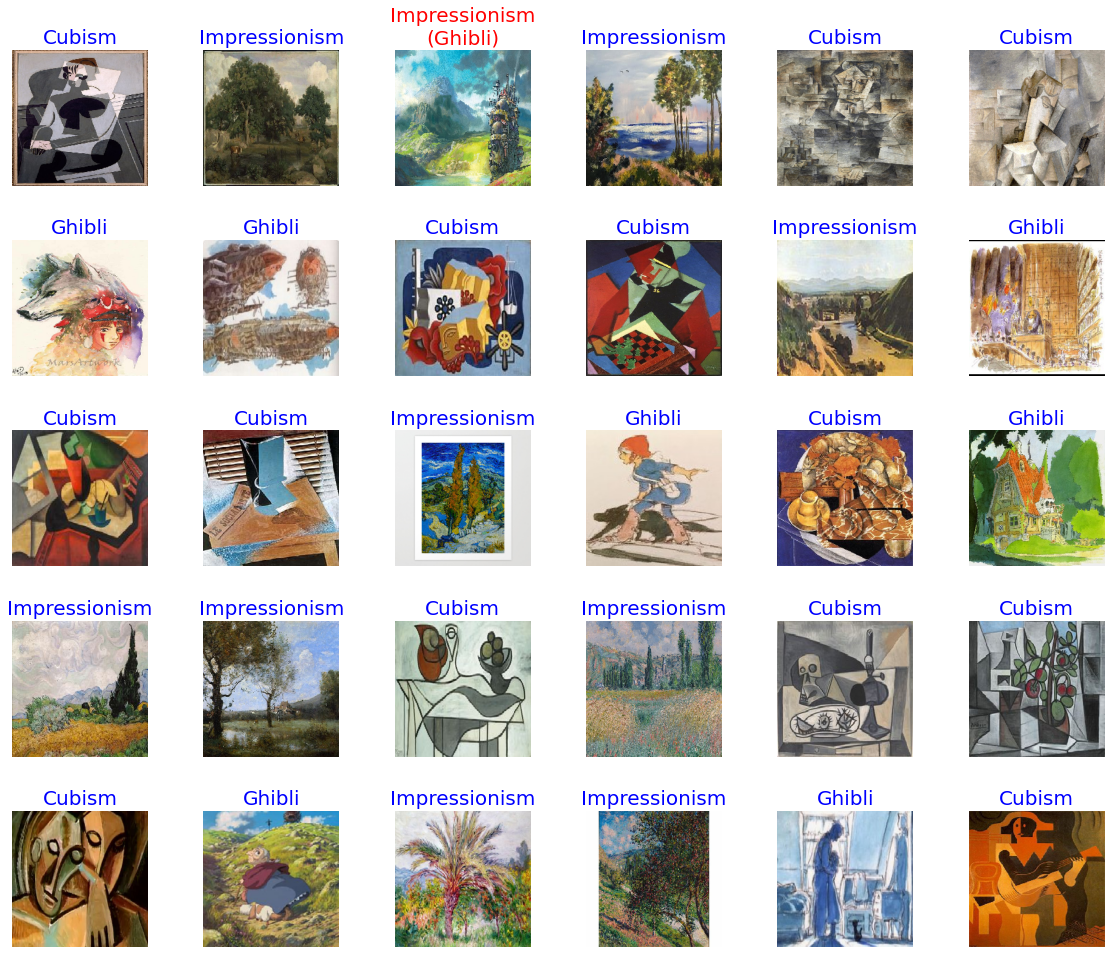

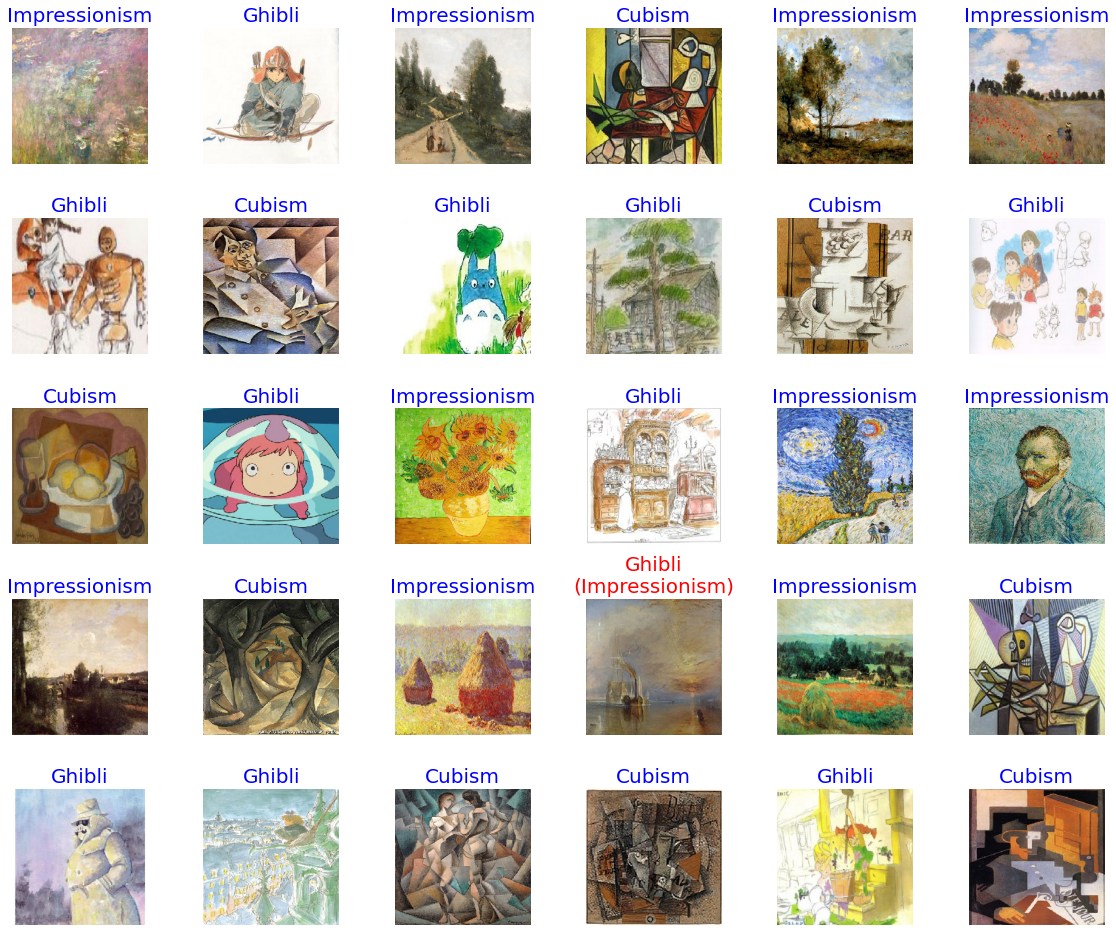

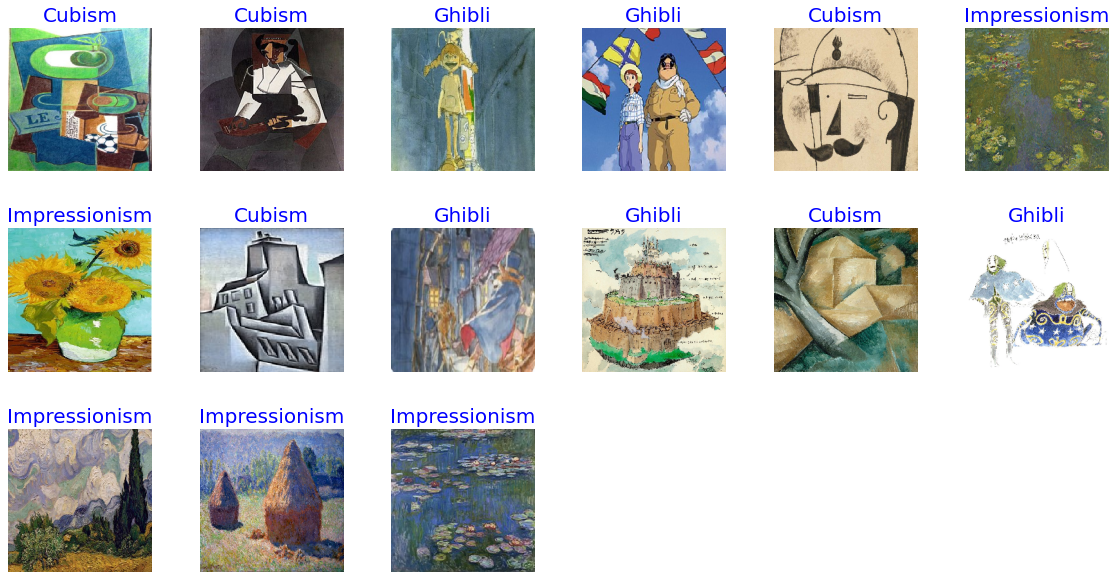

In [13]:
# evaluate the trained model
test_dir = "content/test/eval"

# model.evaluate(test_dir):
# code copied below

image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_generator = image_gen_test.flow_from_directory(batch_size=30,
                                                 directory=test_dir,
                                                 target_size=(config.IMAGE_SIZE, config.IMAGE_SIZE),
                                                 class_mode='sparse')

test_labels = (test_data_generator.class_indices)
test_classes = dict((v,k) for k,v in test_labels.items())
print("test_classes:  {}".format(test_classes))

cols = 6
total = 0
missed = 0
missed_info = ""

for n in range(3) :
    image_batch, label_batch = next(test_data_generator)
    
    total += len(image_batch)
    
    label_batch = label_batch.astype(int)

    predicted_batch = model.keras_model.predict(image_batch)
    predicted_batch = tf.squeeze(predicted_batch).numpy()
    predicted_labels = np.argmax(predicted_batch, axis=-1)

    rows = len(image_batch) // cols + 1
    plt.figure(figsize=(20, 20 * rows // cols))
    plt.subplots_adjust(hspace = 0.4)

    for i in range(len(image_batch)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(image_batch[i])
        plt.axis('off')

        label = label_batch[i]
        label_name = test_classes[label]
        predicted_label = predicted_labels[i]
        predicted_name = model.config.decode_classid(str(predicted_label))

        if predicted_name == label_name:
            color = "blue"
            plt.title(predicted_name.title(), color=color, fontsize=20)
        else:
            missed += 1
            color = "red"
            plt.title("{}\n({})".format(predicted_name.title(), label_name.title()), color=color, fontsize=20)
            
            missed_info += "[MISSED] {} -> {} \n".format(label_name, predicted_name)
            
#             print(image_batch[i])

print("\n=========================================\nEvaluation completed. ")
print("======{:.2%} correct. \n\nMissed {} out of total {} images:".format((total-missed)/total, missed, total))
print(missed_info)
print("=========================================")
